Automating Port Operations 
We first import the necessary libraries and we create train and test folders that will hold the sub folders of different boat images that are split the dataset into train and test in the ratio 80:20. We use os to create and understand the directories, and train test to split. And finally shutil to move the images.

In [12]:
# This code implements a Convolutional Neural Network (CNN) for image classification using TensorFlow and Keras.
# Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import numpy as np
import shutil
from keras.utils import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, BatchNormalization

# Define paths
dataset_dir = 'Automating_Port_Operations_dataset'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each class folder and split the images
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    
    # Skip if not a directory or if it's a train/test folder 
    if not os.path.isdir(class_path) or class_folder in ['train', 'test']:
        continue
    
    images = os.listdir(class_path)
    
    # Filter only images to avoid directories being included by mistake
    images = [img for img in images if os.path.isfile(os.path.join(class_path, img))]
    
    # Proceed only if there are images in the folder
    if len(images) > 0:
        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=43, shuffle=True)
        
        # Create class folders in train and test directories
        train_class_dir = os.path.join(train_dir, class_folder)
        test_class_dir = os.path.join(test_dir, class_folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        # Move the images to the respective directories
        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))
        
        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_class_dir, img))





Since the dataset is very small for each classes, we will use image augmentation to generate 10 augmented images per original image

In [15]:
# Data augmentation generator
aug_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directory paths
base_dir = train_dir
save_base_dir = os.path.join(train_dir, 'augmented_data')
os.makedirs(save_base_dir, exist_ok=True)

# List of classes (directories)
classes = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 
           'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']

# Loop through each class directory
for boat_class in os.listdir(train_dir):
    print(f"Augmenting data for {boat_class}...")
    
    # Directory of the class images
    dir_path = os.path.join(train_dir, boat_class)
    
    # Directory to save augmented images
    save_dir = os.path.join(save_base_dir, boat_class)
    os.makedirs(save_dir, exist_ok=True)
    
    # List of image files
    img_list = os.listdir(dir_path)

    # Filter only image files
    img_list = [f for f in img_list if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Augment each image
    for loc_img in img_list:
        img_path = os.path.join(dir_path, loc_img)
        img = load_img(img_path)  # Load image
        x = img_to_array(img)  # Convert image to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape to add a batch dimension
        
        # Generate and save augmented images
        i = 0
        for batch in aug_datagen.flow(x, batch_size=1, save_to_dir=save_dir, 
                                      save_prefix=boat_class, save_format='jpeg'):
            if i >= 10:  # Generate 10 augmented images per original image
                break
            i += 1




Augmenting data for gondola...
Augmenting data for buoy...
Augmenting data for ferry_boat...
Augmenting data for sailboat...
Augmenting data for augmented_data...
Augmenting data for cruise_ship...
Augmenting data for kayak...
Augmenting data for inflatable_boat...
Augmenting data for freight_boat...
Augmenting data for paper_boat...
Found 8005 images belonging to 10 classes.
Found 1997 images belonging to 10 classes.
Found 247 images belonging to 9 classes.


We use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Both generators will be initialized with data normalization. And we load train, validation and test dataset in batches of 32 using the generators with image size of 256*256.

In [24]:
# Initialize the ImageDataGenerator for training with validation split
# Use ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Initialize the ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train, validation, and test dataset in batches of 32
train_generator = train_datagen.flow_from_directory(
    save_base_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    save_base_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 7273 images belonging to 9 classes.
Found 1814 images belonging to 9 classes.
Found 247 images belonging to 9 classes.


Next we build a CNN network using Keras, then compile it using Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall. Next since the classes are imbalanced and can lead to over-fitting, we compute the class weights of the sub-folders of images using train_generator.classes and moreover create a early stopping callback to deal with over-fitting. We use this class weights and early stopping to fit the model for 10 epochs, and plot training loss and accuracy against epochs.

/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,713 (252.79 KB)

 Trainable params: 64,713 (252.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-30 02:30:46.534033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_665', 436 bytes spill stores, 436 bytes spill loads



 48/113 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.0377 - loss: 2.2116 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

2024-08-30 02:31:06.335504: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_665', 444 bytes spill stores, 444 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 354ms/step - accuracy: 0.0875 - loss: 2.1841 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.1077 - val_loss: 2.1487 - val_precision_5: 0.7273 - val_recall_5: 0.0045
Epoch 2/100
  1/113 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.2188 - loss: 2.1076 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

2024-08-30 02:31:34.350012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:31:34.350049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
/home/rynem8/anaconda3/envs/py312/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-08-30 02:31:34.350067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2188 - loss: 2.1076 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.1364 - val_loss: 2.0358 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/100


2024-08-30 02:31:34.752381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:31:34.752443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 261ms/step - accuracy: 0.1919 - loss: 2.0835 - precision_5: 0.4868 - recall_5: 0.0034 - val_accuracy: 0.2372 - val_loss: 2.0133 - val_precision_5: 0.4167 - val_recall_5: 0.0028
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.2656 - loss: 1.9214 - precision_5: 0.3333 - recall_5: 0.0156 - val_accuracy: 0.2727 - val_loss: 1.9276 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/100


2024-08-30 02:32:06.121943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:32:06.121978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:32:06.121996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:32:06.137794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:32:06.137852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 264ms/step - accuracy: 0.2684 - loss: 1.9541 - precision_5: 0.3587 - recall_5: 0.0126 - val_accuracy: 0.2026 - val_loss: 1.9484 - val_precision_5: 0.2593 - val_recall_5: 0.0039
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - accuracy: 0.3125 - loss: 1.3875 - precision_5: 1.0000 - recall_5: 0.0156 - val_accuracy: 0.1818 - val_loss: 2.0666 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 7/100


2024-08-30 02:32:37.624422: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-30 02:32:37.624486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:32:37.624507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 271ms/step - accuracy: 0.2693 - loss: 1.9583 - precision_5: 0.3618 - recall_5: 0.0114 - val_accuracy: 0.2946 - val_loss: 1.9144 - val_precision_5: 0.3491 - val_recall_5: 0.0329
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.3281 - loss: 2.6516 - precision_5: 0.1667 - recall_5: 0.0156 - val_accuracy: 0.5000 - val_loss: 1.6015 - val_precision_5: 0.8000 - val_recall_5: 0.1818
Epoch 9/100


2024-08-30 02:33:09.977880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:33:09.977922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:33:09.977947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:33:10.003208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:33:10.003351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - accuracy: 0.3010 - loss: 1.8430 - precision_5: 0.5088 - recall_5: 0.0334 - val_accuracy: 0.3460 - val_loss: 1.8308 - val_precision_5: 0.5913 - val_recall_5: 0.0379
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.3906 - loss: 1.3716 - precision_5: 0.8571 - recall_5: 0.0938 - val_accuracy: 0.3182 - val_loss: 1.6755 - val_precision_5: 1.0000 - val_recall_5: 0.0909
Epoch 11/100


2024-08-30 02:33:40.464207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:33:40.464246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:33:40.464264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:33:40.487906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:33:40.487958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - accuracy: 0.3444 - loss: 1.7669 - precision_5: 0.5406 - recall_5: 0.0465 - val_accuracy: 0.3248 - val_loss: 1.8460 - val_precision_5: 0.5896 - val_recall_5: 0.0441
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.3594 - loss: 2.3373 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.2273 - val_loss: 2.0148 - val_precision_5: 0.5000 - val_recall_5: 0.0455
Epoch 13/100


2024-08-30 02:34:13.895035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 269ms/step - accuracy: 0.3292 - loss: 1.7363 - precision_5: 0.5577 - recall_5: 0.0492 - val_accuracy: 0.3315 - val_loss: 1.9251 - val_precision_5: 0.5088 - val_recall_5: 0.0324
Epoch 14/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - accuracy: 0.3125 - loss: 1.6693 - precision_5: 0.5000 - recall_5: 0.0156 - val_accuracy: 0.0909 - val_loss: 2.2434 - val_precision_5: 0.5000 - val_recall_5: 0.0455
Epoch 15/100


2024-08-30 02:34:46.297517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:34:46.297561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:34:46.297581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:34:46.314411: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:34:46.314461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 288ms/step - accuracy: 0.3299 - loss: 1.7183 - precision_5: 0.5420 - recall_5: 0.0590 - val_accuracy: 0.3538 - val_loss: 1.8555 - val_precision_5: 0.5433 - val_recall_5: 0.0631
Epoch 16/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.2188 - loss: 2.2585 - precision_5: 0.6667 - recall_5: 0.0625 - val_accuracy: 0.2273 - val_loss: 2.0637 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 17/100


2024-08-30 02:35:20.641114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:35:20.641175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:35:20.641201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:35:20.660555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:35:20.660607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 293ms/step - accuracy: 0.3530 - loss: 1.6338 - precision_5: 0.5810 - recall_5: 0.0855 - val_accuracy: 0.3248 - val_loss: 1.8068 - val_precision_5: 0.5255 - val_recall_5: 0.0575
Epoch 18/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.3906 - loss: 1.3096 - precision_5: 0.4000 - recall_5: 0.0312 - val_accuracy: 0.4091 - val_loss: 1.5821 - val_precision_5: 0.5000 - val_recall_5: 0.1364
Epoch 19/100


2024-08-30 02:35:55.539886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:35:55.539933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:35:55.539954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:35:55.563291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:35:55.563355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 322ms/step - accuracy: 0.3769 - loss: 1.5739 - precision_5: 0.5840 - recall_5: 0.1051 - val_accuracy: 0.3477 - val_loss: 1.7511 - val_precision_5: 0.5174 - val_recall_5: 0.0831
Epoch 20/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.3906 - loss: 1.6381 - precision_5: 0.4667 - recall_5: 0.1094 - val_accuracy: 0.3182 - val_loss: 1.8286 - val_precision_5: 1.0000 - val_recall_5: 0.0455
Epoch 21/100


2024-08-30 02:36:33.870918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:36:33.870977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - accuracy: 0.3590 - loss: 1.5668 - precision_5: 0.5628 - recall_5: 0.1070 - val_accuracy: 0.4001 - val_loss: 1.6665 - val_precision_5: 0.5752 - val_recall_5: 0.1088
Epoch 22/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - accuracy: 0.3594 - loss: 1.0454 - precision_5: 0.5625 - recall_5: 0.1406 - val_accuracy: 0.2727 - val_loss: 2.0947 - val_precision_5: 0.3333 - val_recall_5: 0.0455
Epoch 23/100


2024-08-30 02:37:10.279234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:37:10.279308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:37:10.279328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:37:10.296406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:37:10.296466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 286ms/step - accuracy: 0.3973 - loss: 1.4647 - precision_5: 0.6073 - recall_5: 0.1440 - val_accuracy: 0.3940 - val_loss: 1.5964 - val_precision_5: 0.5987 - val_recall_5: 0.2065
Epoch 24/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.3750 - loss: 2.1103 - precision_5: 0.5000 - recall_5: 0.1875 - val_accuracy: 0.4545 - val_loss: 1.4674 - val_precision_5: 0.5000 - val_recall_5: 0.2273
Epoch 25/100


2024-08-30 02:37:44.466016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:37:44.466059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:37:44.466080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:37:44.481600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:37:44.481666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 299ms/step - accuracy: 0.3960 - loss: 1.4296 - precision_5: 0.6050 - recall_5: 0.1724 - val_accuracy: 0.4124 - val_loss: 1.6570 - val_precision_5: 0.5725 - val_recall_5: 0.1323
Epoch 26/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.4531 - loss: 1.2153 - precision_5: 0.7647 - recall_5: 0.2031 - val_accuracy: 0.3182 - val_loss: 1.5042 - val_precision_5: 0.6000 - val_recall_5: 0.1364
Epoch 27/100


2024-08-30 02:38:20.201683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:38:20.201730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:38:20.201751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:38:20.223908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:38:20.223961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.4123 - loss: 1.3973 - precision_5: 0.6163 - recall_5: 0.1919 - val_accuracy: 0.4146 - val_loss: 1.5623 - val_precision_5: 0.6688 - val_recall_5: 0.1780
Epoch 28/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.3594 - loss: 1.2570 - precision_5: 0.7333 - recall_5: 0.1719 - val_accuracy: 0.4545 - val_loss: 1.5691 - val_precision_5: 0.8333 - val_recall_5: 0.2273
Epoch 29/100


2024-08-30 02:38:55.710899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:38:55.710947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:38:55.710970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:38:55.741895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:38:55.741954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.4239 - loss: 1.3747 - precision_5: 0.6172 - recall_5: 0.1879 - val_accuracy: 0.4291 - val_loss: 1.5159 - val_precision_5: 0.6349 - val_recall_5: 0.2048
Epoch 30/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.4062 - loss: 1.2092 - precision_5: 0.7222 - recall_5: 0.2031 - val_accuracy: 0.2727 - val_loss: 2.1103 - val_precision_5: 0.3333 - val_recall_5: 0.0909
Epoch 31/100


2024-08-30 02:39:31.830785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:39:31.830838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:39:31.830865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:39:31.855558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:39:31.855620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step - accuracy: 0.4220 - loss: 1.3551 - precision_5: 0.6219 - recall_5: 0.2111 - val_accuracy: 0.4587 - val_loss: 1.5072 - val_precision_5: 0.6137 - val_recall_5: 0.2243
Epoch 32/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.4375 - loss: 1.4062 - precision_5: 0.7391 - recall_5: 0.2656 - val_accuracy: 0.4091 - val_loss: 1.3368 - val_precision_5: 0.7778 - val_recall_5: 0.3182
Epoch 33/100


2024-08-30 02:40:07.470782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:40:07.470822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:40:07.470841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:40:07.496370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:40:07.496430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.4399 - loss: 1.2590 - precision_5: 0.6022 - recall_5: 0.2285 - val_accuracy: 0.4141 - val_loss: 1.5305 - val_precision_5: 0.6266 - val_recall_5: 0.1948
Epoch 34/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.4375 - loss: 1.4290 - precision_5: 0.6875 - recall_5: 0.1719 - val_accuracy: 0.4545 - val_loss: 1.5560 - val_precision_5: 0.6250 - val_recall_5: 0.2273
Epoch 35/100


2024-08-30 02:40:41.637817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:40:41.637877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:40:41.637899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:40:41.664194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:40:41.664254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.4642 - loss: 1.2205 - precision_5: 0.6272 - recall_5: 0.2428 - val_accuracy: 0.4849 - val_loss: 1.3513 - val_precision_5: 0.6898 - val_recall_5: 0.2667
Epoch 36/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5156 - loss: 1.3686 - precision_5: 0.6400 - recall_5: 0.2500 - val_accuracy: 0.5455 - val_loss: 1.1613 - val_precision_5: 0.8571 - val_recall_5: 0.2727
Epoch 37/100


2024-08-30 02:41:18.088634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:41:18.088684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:41:18.088709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:41:18.117769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:41:18.117834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step - accuracy: 0.4517 - loss: 1.2110 - precision_5: 0.6371 - recall_5: 0.2538 - val_accuracy: 0.4325 - val_loss: 1.4484 - val_precision_5: 0.6583 - val_recall_5: 0.2333
Epoch 38/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.4531 - loss: 0.9785 - precision_5: 0.6538 - recall_5: 0.2656 - val_accuracy: 0.6364 - val_loss: 1.0398 - val_precision_5: 0.7500 - val_recall_5: 0.4091
Epoch 39/100


2024-08-30 02:41:54.046904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:41:54.046954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:41:54.046980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:41:54.081344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:41:54.081402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - accuracy: 0.4619 - loss: 1.2116 - precision_5: 0.6529 - recall_5: 0.2724 - val_accuracy: 0.4615 - val_loss: 1.3883 - val_precision_5: 0.6097 - val_recall_5: 0.2807
Epoch 40/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.5781 - loss: 1.2277 - precision_5: 0.6667 - recall_5: 0.3438 - val_accuracy: 0.5000 - val_loss: 1.3577 - val_precision_5: 0.7778 - val_recall_5: 0.3182
Epoch 41/100


2024-08-30 02:42:29.367144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:42:29.367188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:42:29.367215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:42:29.387769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:42:29.387821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - accuracy: 0.4705 - loss: 1.1347 - precision_5: 0.6305 - recall_5: 0.2871 - val_accuracy: 0.4632 - val_loss: 1.3858 - val_precision_5: 0.6110 - val_recall_5: 0.3041
Epoch 42/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5625 - loss: 1.3075 - precision_5: 0.8333 - recall_5: 0.3125 - val_accuracy: 0.3182 - val_loss: 1.6213 - val_precision_5: 0.4286 - val_recall_5: 0.2727
Epoch 43/100


2024-08-30 02:43:04.905346: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:43:04.905755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step - accuracy: 0.5091 - loss: 1.0384 - precision_5: 0.6385 - recall_5: 0.3213 - val_accuracy: 0.4598 - val_loss: 1.3929 - val_precision_5: 0.6064 - val_recall_5: 0.2974
Epoch 44/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - accuracy: 0.4531 - loss: 1.3897 - precision_5: 0.5938 - recall_5: 0.2969 - val_accuracy: 0.5000 - val_loss: 1.4047 - val_precision_5: 0.6667 - val_recall_5: 0.2727
Epoch 45/100


2024-08-30 02:43:40.551043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:43:40.551091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:43:40.551113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:43:40.571286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:43:40.571347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 304ms/step - accuracy: 0.4826 - loss: 1.0665 - precision_5: 0.6264 - recall_5: 0.3118 - val_accuracy: 0.4810 - val_loss: 1.3580 - val_precision_5: 0.6295 - val_recall_5: 0.3309
Epoch 46/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.5625 - loss: 0.6605 - precision_5: 0.8000 - recall_5: 0.4375 - val_accuracy: 0.3636 - val_loss: 1.6268 - val_precision_5: 0.5556 - val_recall_5: 0.2273
Epoch 47/100


2024-08-30 02:44:16.992448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:44:16.992506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 298ms/step - accuracy: 0.5209 - loss: 1.0084 - precision_5: 0.6586 - recall_5: 0.3513 - val_accuracy: 0.4498 - val_loss: 1.4517 - val_precision_5: 0.5546 - val_recall_5: 0.3147
Epoch 48/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.4688 - loss: 0.8972 - precision_5: 0.5676 - recall_5: 0.3281 - val_accuracy: 0.2727 - val_loss: 1.5470 - val_precision_5: 0.5714 - val_recall_5: 0.1818
Epoch 49/100


2024-08-30 02:44:52.846900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:44:52.847185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:44:52.847228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:44:52.870457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:44:52.870510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step - accuracy: 0.5114 - loss: 1.0354 - precision_5: 0.6481 - recall_5: 0.3518 - val_accuracy: 0.5112 - val_loss: 1.2507 - val_precision_5: 0.6543 - val_recall_5: 0.3538
Epoch 50/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5156 - loss: 0.8623 - precision_5: 0.6970 - recall_5: 0.3594 - val_accuracy: 0.5000 - val_loss: 1.4915 - val_precision_5: 0.5000 - val_recall_5: 0.2727
Epoch 51/100


2024-08-30 02:45:28.853463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:45:28.853954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:45:28.853984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:45:28.892988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:45:28.893048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.5234 - loss: 0.9683 - precision_5: 0.6700 - recall_5: 0.3680 - val_accuracy: 0.4833 - val_loss: 1.3580 - val_precision_5: 0.5965 - val_recall_5: 0.3449
Epoch 52/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.5156 - loss: 0.9045 - precision_5: 0.6667 - recall_5: 0.3750 - val_accuracy: 0.5455 - val_loss: 1.4539 - val_precision_5: 0.5882 - val_recall_5: 0.4545
Epoch 53/100


2024-08-30 02:46:04.772029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:46:04.772085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:46:04.772114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:46:04.803815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:46:04.803877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - accuracy: 0.5363 - loss: 0.9057 - precision_5: 0.6819 - recall_5: 0.3961 - val_accuracy: 0.4570 - val_loss: 1.3694 - val_precision_5: 0.6019 - val_recall_5: 0.3231
Epoch 54/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.4844 - loss: 1.0682 - precision_5: 0.5000 - recall_5: 0.2344 - val_accuracy: 0.5909 - val_loss: 1.2126 - val_precision_5: 0.7500 - val_recall_5: 0.4091
Epoch 55/100


2024-08-30 02:46:41.363788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:46:41.363826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:46:41.363846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:46:41.404276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:46:41.404369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 298ms/step - accuracy: 0.5416 - loss: 0.9137 - precision_5: 0.6797 - recall_5: 0.3806 - val_accuracy: 0.5201 - val_loss: 1.2273 - val_precision_5: 0.6372 - val_recall_5: 0.3940
Epoch 56/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.5469 - loss: 0.7426 - precision_5: 0.6765 - recall_5: 0.3594 - val_accuracy: 0.3636 - val_loss: 1.5886 - val_precision_5: 0.5000 - val_recall_5: 0.2273
Epoch 57/100


2024-08-30 02:47:17.192287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:47:17.192983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:47:17.193035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:47:17.224294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:47:17.224361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - accuracy: 0.5605 - loss: 0.8724 - precision_5: 0.6963 - recall_5: 0.4217 - val_accuracy: 0.5642 - val_loss: 1.1805 - val_precision_5: 0.6805 - val_recall_5: 0.4208
Epoch 58/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.5781 - loss: 0.6942 - precision_5: 0.7111 - recall_5: 0.5000 - val_accuracy: 0.4545 - val_loss: 1.3166 - val_precision_5: 0.5333 - val_recall_5: 0.3636
Epoch 59/100


2024-08-30 02:47:51.402634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:47:51.402694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:47:51.402716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:47:51.428431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:47:51.428500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.5776 - loss: 0.8581 - precision_5: 0.6936 - recall_5: 0.4250 - val_accuracy: 0.4944 - val_loss: 1.3191 - val_precision_5: 0.6034 - val_recall_5: 0.3599
Epoch 60/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.5625 - loss: 0.9178 - precision_5: 0.6500 - recall_5: 0.4062 - val_accuracy: 0.5909 - val_loss: 1.2456 - val_precision_5: 0.6667 - val_recall_5: 0.2727
Epoch 61/100


2024-08-30 02:48:26.932449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:48:26.932494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:48:26.932519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:48:26.975803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:48:26.975863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.5752 - loss: 0.8459 - precision_5: 0.6976 - recall_5: 0.4385 - val_accuracy: 0.5061 - val_loss: 1.2794 - val_precision_5: 0.6138 - val_recall_5: 0.3761
Epoch 62/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.5469 - loss: 0.6564 - precision_5: 0.6667 - recall_5: 0.4062 - val_accuracy: 0.4545 - val_loss: 0.9719 - val_precision_5: 0.7500 - val_recall_5: 0.4091
Epoch 63/100


2024-08-30 02:49:03.539139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:49:03.539186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:49:03.539213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:49:03.575664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:49:03.575732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.5888 - loss: 0.8044 - precision_5: 0.7116 - recall_5: 0.4452 - val_accuracy: 0.5318 - val_loss: 1.2350 - val_precision_5: 0.6312 - val_recall_5: 0.4001
Epoch 64/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.5312 - loss: 0.7808 - precision_5: 0.7027 - recall_5: 0.4062 - val_accuracy: 0.6818 - val_loss: 1.0024 - val_precision_5: 0.7778 - val_recall_5: 0.6364
Epoch 65/100


2024-08-30 02:49:39.962737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:49:39.962781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:49:39.962802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:49:39.989033: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:49:39.989110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 304ms/step - accuracy: 0.6134 - loss: 0.7575 - precision_5: 0.7330 - recall_5: 0.4751 - val_accuracy: 0.5335 - val_loss: 1.1623 - val_precision_5: 0.6499 - val_recall_5: 0.4247
Epoch 66/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 0.5781 - loss: 0.7768 - precision_5: 0.6275 - recall_5: 0.5000 - val_accuracy: 0.5909 - val_loss: 1.2209 - val_precision_5: 0.5556 - val_recall_5: 0.4545
Epoch 67/100


2024-08-30 02:50:16.377578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:50:16.377943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:50:16.377968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:50:16.404536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:50:16.404591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 292ms/step - accuracy: 0.6041 - loss: 0.7576 - precision_5: 0.7321 - recall_5: 0.4802 - val_accuracy: 0.5848 - val_loss: 1.0632 - val_precision_5: 0.6888 - val_recall_5: 0.4632
Epoch 68/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.7031 - loss: 0.5275 - precision_5: 0.7872 - recall_5: 0.5781 - val_accuracy: 0.5909 - val_loss: 1.2344 - val_precision_5: 0.7333 - val_recall_5: 0.5000
Epoch 69/100


2024-08-30 02:50:51.513489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:50:51.513911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:50:51.513962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:50:51.544080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:50:51.544132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.6240 - loss: 0.7191 - precision_5: 0.7400 - recall_5: 0.4989 - val_accuracy: 0.5943 - val_loss: 1.0505 - val_precision_5: 0.7095 - val_recall_5: 0.4771
Epoch 70/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.5938 - loss: 0.7592 - precision_5: 0.6818 - recall_5: 0.4688 - val_accuracy: 0.5000 - val_loss: 1.3802 - val_precision_5: 0.6154 - val_recall_5: 0.3636
Epoch 71/100


2024-08-30 02:51:28.126766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:51:28.126802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:51:28.126823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:51:28.156242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:51:28.156296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - accuracy: 0.6146 - loss: 0.7184 - precision_5: 0.7149 - recall_5: 0.4920 - val_accuracy: 0.5312 - val_loss: 1.2497 - val_precision_5: 0.6142 - val_recall_5: 0.4096
Epoch 72/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.4219 - loss: 1.1481 - precision_5: 0.5349 - recall_5: 0.3594 - val_accuracy: 0.5455 - val_loss: 1.5732 - val_precision_5: 0.5625 - val_recall_5: 0.4091
Epoch 73/100


2024-08-30 02:52:03.576229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:52:03.576267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:52:03.576288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:52:03.603400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:52:03.603466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.6021 - loss: 0.7411 - precision_5: 0.7116 - recall_5: 0.4839 - val_accuracy: 0.5815 - val_loss: 1.1353 - val_precision_5: 0.6664 - val_recall_5: 0.4704
Epoch 74/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.5625 - loss: 0.7885 - precision_5: 0.6977 - recall_5: 0.4688 - val_accuracy: 0.6364 - val_loss: 0.9809 - val_precision_5: 0.7143 - val_recall_5: 0.4545
Epoch 75/100


2024-08-30 02:52:39.527480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:52:39.527543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:52:39.527562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:52:39.553893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:52:39.553948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - accuracy: 0.6271 - loss: 0.6879 - precision_5: 0.7276 - recall_5: 0.5184 - val_accuracy: 0.5664 - val_loss: 1.1268 - val_precision_5: 0.6651 - val_recall_5: 0.4743
Epoch 76/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.6094 - loss: 0.6279 - precision_5: 0.7955 - recall_5: 0.5469 - val_accuracy: 0.5909 - val_loss: 1.3003 - val_precision_5: 0.6429 - val_recall_5: 0.4091
Epoch 77/100


2024-08-30 02:53:15.694090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:53:15.694423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:53:15.694459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:53:15.725993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:53:15.726059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 288ms/step - accuracy: 0.6406 - loss: 0.6596 - precision_5: 0.7390 - recall_5: 0.5334 - val_accuracy: 0.6222 - val_loss: 0.9787 - val_precision_5: 0.7146 - val_recall_5: 0.5073
Epoch 78/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.6875 - loss: 0.4702 - precision_5: 0.8723 - recall_5: 0.6406 - val_accuracy: 0.5909 - val_loss: 1.0210 - val_precision_5: 0.6875 - val_recall_5: 0.5000
Epoch 79/100


2024-08-30 02:53:50.270633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:53:50.270681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:53:50.270704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:53:50.295140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:53:50.295197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - accuracy: 0.6645 - loss: 0.6119 - precision_5: 0.7646 - recall_5: 0.5522 - val_accuracy: 0.6194 - val_loss: 1.0231 - val_precision_5: 0.7074 - val_recall_5: 0.5206
Epoch 80/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.6250 - loss: 0.5840 - precision_5: 0.7234 - recall_5: 0.5312 - val_accuracy: 0.5455 - val_loss: 1.0912 - val_precision_5: 0.7143 - val_recall_5: 0.4545
Epoch 81/100


2024-08-30 02:54:26.905827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:54:26.905867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:54:26.905886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:54:26.930319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:54:26.930381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - accuracy: 0.6715 - loss: 0.5889 - precision_5: 0.7703 - recall_5: 0.5677 - val_accuracy: 0.6278 - val_loss: 0.9782 - val_precision_5: 0.7180 - val_recall_5: 0.5173
Epoch 82/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6719 - loss: 0.6699 - precision_5: 0.7917 - recall_5: 0.5938 - val_accuracy: 0.7273 - val_loss: 0.7534 - val_precision_5: 0.7895 - val_recall_5: 0.6818
Epoch 83/100


2024-08-30 02:55:07.519296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:55:07.519582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:55:07.519608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:55:07.556891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:55:07.556949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.6744 - loss: 0.5899 - precision_5: 0.7670 - recall_5: 0.5799 - val_accuracy: 0.5876 - val_loss: 1.0626 - val_precision_5: 0.6676 - val_recall_5: 0.5112
Epoch 84/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.6250 - loss: 0.6931 - precision_5: 0.6735 - recall_5: 0.5156 - val_accuracy: 0.6364 - val_loss: 1.2676 - val_precision_5: 0.5714 - val_recall_5: 0.3636
Epoch 85/100


2024-08-30 02:55:43.038778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:55:43.038822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:55:43.038847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:55:43.063745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:55:43.063809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - accuracy: 0.6816 - loss: 0.5718 - precision_5: 0.7597 - recall_5: 0.5845 - val_accuracy: 0.6155 - val_loss: 1.0084 - val_precision_5: 0.7060 - val_recall_5: 0.5240
Epoch 86/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.7656 - loss: 0.5022 - precision_5: 0.8846 - recall_5: 0.7188 - val_accuracy: 0.5909 - val_loss: 0.9359 - val_precision_5: 0.6923 - val_recall_5: 0.4091
Epoch 87/100


2024-08-30 02:56:19.630172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:56:19.630215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:56:19.630236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:56:19.656356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:56:19.656412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.6999 - loss: 0.5371 - precision_5: 0.7869 - recall_5: 0.6022 - val_accuracy: 0.6295 - val_loss: 0.9499 - val_precision_5: 0.7142 - val_recall_5: 0.5424
Epoch 88/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.5625 - loss: 0.6876 - precision_5: 0.6444 - recall_5: 0.4531 - val_accuracy: 0.4091 - val_loss: 1.2368 - val_precision_5: 0.5833 - val_recall_5: 0.3182
Epoch 89/100


2024-08-30 02:56:56.852618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:56:56.852657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:56:56.852678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:56:56.874926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:56:56.874989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step - accuracy: 0.7047 - loss: 0.5259 - precision_5: 0.7797 - recall_5: 0.6137 - val_accuracy: 0.6484 - val_loss: 0.9595 - val_precision_5: 0.7280 - val_recall_5: 0.5541
Epoch 90/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.5938 - loss: 0.6920 - precision_5: 0.7391 - recall_5: 0.5312 - val_accuracy: 0.5455 - val_loss: 1.1304 - val_precision_5: 0.6250 - val_recall_5: 0.4545
Epoch 91/100


2024-08-30 02:57:32.612159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:57:32.612199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:57:32.612225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:57:32.639249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:57:32.639306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 304ms/step - accuracy: 0.7072 - loss: 0.5203 - precision_5: 0.7828 - recall_5: 0.6171 - val_accuracy: 0.5631 - val_loss: 1.2056 - val_precision_5: 0.6185 - val_recall_5: 0.4749
Epoch 92/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.5781 - loss: 0.7318 - precision_5: 0.6200 - recall_5: 0.4844 - val_accuracy: 0.5909 - val_loss: 1.0362 - val_precision_5: 0.5556 - val_recall_5: 0.4545
Epoch 93/100


2024-08-30 02:58:09.035147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:58:09.035185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:58:09.035204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:58:09.060197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:58:09.060262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 308ms/step - accuracy: 0.6888 - loss: 0.5768 - precision_5: 0.7625 - recall_5: 0.5886 - val_accuracy: 0.6066 - val_loss: 1.0371 - val_precision_5: 0.6824 - val_recall_5: 0.5324
Epoch 94/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.5312 - loss: 0.7449 - precision_5: 0.6087 - recall_5: 0.4375 - val_accuracy: 0.5909 - val_loss: 0.9906 - val_precision_5: 0.6875 - val_recall_5: 0.5000
Epoch 95/100


2024-08-30 02:58:46.030766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:58:46.030827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:58:46.030851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:58:46.063165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:58:46.063235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step - accuracy: 0.6896 - loss: 0.5619 - precision_5: 0.7638 - recall_5: 0.5964 - val_accuracy: 0.6256 - val_loss: 0.9714 - val_precision_5: 0.6938 - val_recall_5: 0.5564
Epoch 96/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.7188 - loss: 0.4434 - precision_5: 0.8125 - recall_5: 0.6094 - val_accuracy: 0.6364 - val_loss: 0.9829 - val_precision_5: 0.7500 - val_recall_5: 0.4091
Epoch 97/100


2024-08-30 02:59:22.017006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:59:22.017052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:59:22.017073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:59:22.045114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:59:22.045172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 311ms/step - accuracy: 0.7158 - loss: 0.4901 - precision_5: 0.7967 - recall_5: 0.6374 - val_accuracy: 0.6786 - val_loss: 0.8597 - val_precision_5: 0.7479 - val_recall_5: 0.5926
Epoch 98/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.6719 - loss: 0.6143 - precision_5: 0.7826 - recall_5: 0.5625 - val_accuracy: 0.7727 - val_loss: 0.9833 - val_precision_5: 0.8000 - val_recall_5: 0.5455
Epoch 99/100


2024-08-30 02:59:59.218374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 02:59:59.218423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:59:59.218446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 02:59:59.241413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 02:59:59.241465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.7395 - loss: 0.4682 - precision_5: 0.8094 - recall_5: 0.6584 - val_accuracy: 0.6546 - val_loss: 0.9466 - val_precision_5: 0.7231 - val_recall_5: 0.5742
Epoch 100/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.6875 - loss: 0.4953 - precision_5: 0.7959 - recall_5: 0.6094 - val_accuracy: 0.6364 - val_loss: 0.8903 - val_precision_5: 0.7500 - val_recall_5: 0.5455
Restoring model weights from the end of the best epoch: 82.


2024-08-30 03:00:36.189322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-30 03:00:36.189390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 03:00:36.189417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352
2024-08-30 03:00:36.246485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-30 03:00:36.246709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17045812112909743352


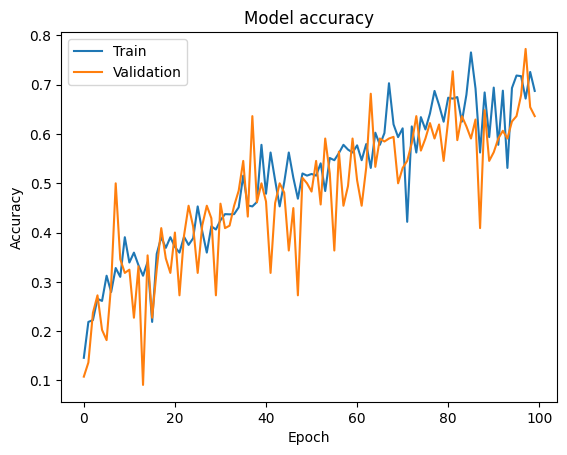

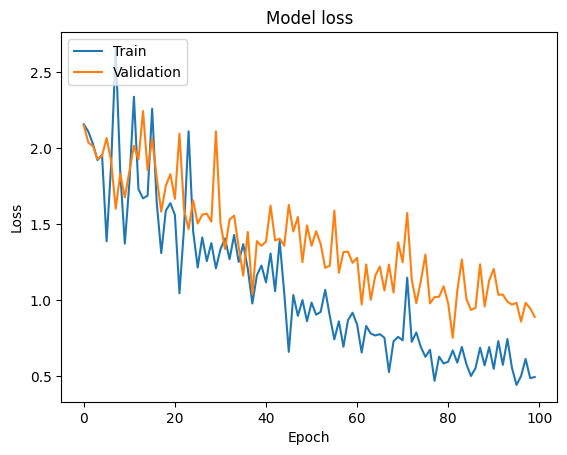

In [25]:

# Build the CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

model.summary()


# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Calculating class weights to address imbalance
# Get the class indices for the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

# Now, training the model again with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)]
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Finally, we evaluate the model on test images and print the test loss and accuracy and plot heatmap of the confusion matrix and print classification report. However, we get a bad performing model as the model has only 34% accuracy with test images. And to get trained well in differentiating different types of boats we need a better dataset or a pre-trained model that can help in indentifying the images at the start.  

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4517 - loss: 2.6876 - precision_5: 0.4772 - recall_5: 0.3584
Test Loss: 2.3527770042419434
Test Accuracy: 0.4170040488243103
Test Precision: 0.4486486613750458
Test Recall: 0.3360323905944824
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step


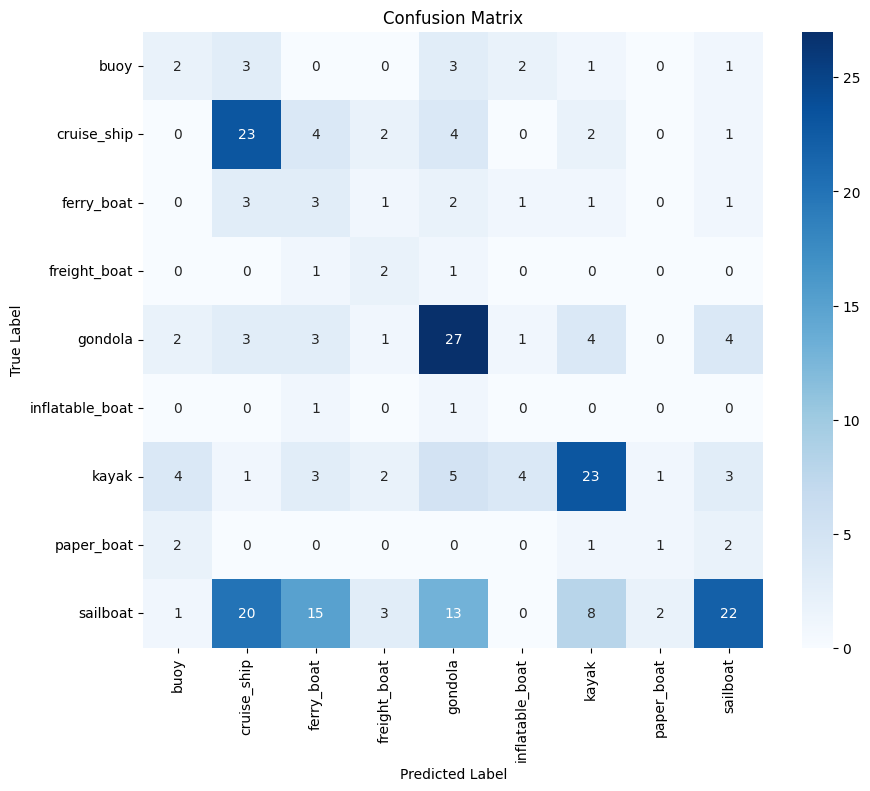

Classification Report
                 precision    recall  f1-score   support

           buoy       0.18      0.17      0.17        12
    cruise_ship       0.43      0.64      0.52        36
     ferry_boat       0.10      0.25      0.14        12
   freight_boat       0.18      0.50      0.27         4
        gondola       0.48      0.60      0.53        45
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.57      0.50      0.53        46
     paper_boat       0.25      0.17      0.20         6
       sailboat       0.65      0.26      0.37        84

       accuracy                           0.42       247
      macro avg       0.32      0.34      0.30       247
   weighted avg       0.50      0.42      0.42       247



In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')


# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


Alternatively, we use transfer learning by utilizing a lightweight model like MobileNetV2, a popular lightweight pre-trained model built using Keras API. We can use this pre-trained model as the initial layer to our new model that will use the pre-trained weights of its CNN layers to identify the image and that we will use additional dense layers to classify the image. 
Now, we first use Keras ImageDataGenerator as used before, however will use the original image directory instead of augmented image directory.

In [6]:
# Initialize ImageDataGenerator for transfer learning model
train_datagen_v2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Testing data does not need a validation split
test_datagen_v2 = ImageDataGenerator(rescale=1./255)

# Load data
train_generator_v2 = train_datagen_v2.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # MobileNetV2 requires 224x224 images
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator_v2 = train_datagen_v2.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator_v2 = test_datagen_v2.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 735 images belonging to 9 classes.
Found 180 images belonging to 9 classes.
Found 247 images belonging to 9 classes.


Next we load MobileNetV2 - Keras Light Model and set its weights as not trainable and use this in our model as the first layer. This is followed up with normal dense layers. We use same optimizers, loss and metrics for compiling this model. And fit the model using compute class weight and early stopping for countering over-fitting.

In [8]:

# Load MobileNetV2 with pre-trained weights from ImageNet, excluding the top layers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Set base model layers to be non-trainable (freezing them)
base_model.trainable = False

# Build the transfer learning model
model_v2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(9, activation='softmax')
])

model_v2.summary()

# Compile the model
model_v2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Get the class indices for the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator_v2.classes),
    y=train_generator_v2.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

# Train the model
history_v2 = model_v2.fit(
    train_generator_v2,
    steps_per_epoch=train_generator_v2.samples // train_generator_v2.batch_size,
    validation_data=validation_generator_v2,
    validation_steps=validation_generator_v2.samples // validation_generator_v2.batch_size,
    epochs=50,
    callbacks=[early_stopping],
    class_weight= class_weights
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,513 (10.00 MB)

 Trainable params: 362,761 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

{0: 2.474747474747475, 1: 0.6586021505376344, 2: 1.991869918699187, 3: 5.104166666666667, 4: 0.6862745098039216, 5: 6.805555555555555, 6: 0.6481481481481481, 7: 4.083333333333333, 8: 0.33469945355191255}
Epoch 1/50


/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724897309.442874  890168 service.cc:146] XLA service 0x7ff930003030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724897309.442941  890168 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-08-29 03:08:29.557401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 03:08:30.080192: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN versi

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0868 - loss: 2.4606 - precision_1: 0.0966 - recall_1: 0.0278         

I0000 00:00:1724897316.591913  890168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2798 - loss: 2.4125 - precision_1: 0.3846 - recall_1: 0.1502

2024-08-29 03:08:46.280932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1230', 148 bytes spill stores, 148 bytes spill loads



22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 529ms/step - accuracy: 0.2853 - loss: 2.3943 - precision_1: 0.3924 - recall_1: 0.1553 - val_accuracy: 0.7312 - val_loss: 1.0103 - val_precision_1: 0.9104 - val_recall_1: 0.3812
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4688 - loss: 0.8764 - precision_1: 0.5789 - recall_1: 0.3438

2024-08-29 03:08:47.798509: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-29 03:08:47.798549: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-08-29 03:08:47.798556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:08:47.798560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
/home/rynem8/anaconda3/envs/py312/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  sel

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.4688 - loss: 0.8764 - precision_1: 0.5789 - recall_1: 0.3438 - val_accuracy: 0.8500 - val_loss: 0.7691 - val_precision_1: 0.9231 - val_recall_1: 0.6000
Epoch 3/50


2024-08-29 03:08:52.525492: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.6314 - loss: 0.6614 - precision_1: 0.7289 - recall_1: 0.5461 - val_accuracy: 0.8500 - val_loss: 0.6496 - val_precision_1: 0.9147 - val_recall_1: 0.7375
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6562 - loss: 0.5753 - precision_1: 0.7308 - recall_1: 0.5938 - val_accuracy: 0.9500 - val_loss: 0.4715 - val_precision_1: 1.0000 - val_recall_1: 0.8000
Epoch 5/50


2024-08-29 03:08:55.442460: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8090 - loss: 0.4576 - precision_1: 0.8992 - recall_1: 0.7453 - val_accuracy: 0.8562 - val_loss: 0.5416 - val_precision_1: 0.9103 - val_recall_1: 0.8250
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.3386 - precision_1: 0.9667 - recall_1: 0.9062 - val_accuracy: 0.8500 - val_loss: 0.4837 - val_precision_1: 1.0000 - val_recall_1: 0.7500
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8766 - loss: 0.2482 - precision_1: 0.9072 - recall_1: 0.8258 - val_accuracy: 0.8687 - val_loss: 0.4713 - val_precision_1: 0.9296 - val_recall_1: 0.8250
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.2639 - precision_1: 0.9375 - recall_1: 0.9375 - val_accuracy: 0.9000 - val_loss: 0.7491 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 9/50


2024-08-29 03:09:01.296364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:01.296401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-29 03:09:01.315527: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9168 - loss: 0.2170 - precision_1: 0.9562 - recall_1: 0.8481 - val_accuracy: 0.8687 - val_loss: 0.4944 - val_precision_1: 0.9231 - val_recall_1: 0.8250
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.1480 - precision_1: 0.8966 - recall_1: 0.8125 - val_accuracy: 0.8500 - val_loss: 0.2843 - val_precision_1: 0.9444 - val_recall_1: 0.8500
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9150 - loss: 0.1903 - precision_1: 0.9498 - recall_1: 0.8692 - val_accuracy: 0.8875 - val_loss: 0.4530 - val_precision_1: 0.9241 - val_recall_1: 0.8375
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0878 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.8500 - val_loss: 0.6832 - val_precision_1: 0.8500 - val_recall_1: 0.8500
Epoch 13/50


2024-08-29 03:09:07.234842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:07.234877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9369 - loss: 0.1262 - precision_1: 0.9601 - recall_1: 0.9198 - val_accuracy: 0.8813 - val_loss: 0.4992 - val_precision_1: 0.9116 - val_recall_1: 0.8375
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.1766 - precision_1: 0.9310 - recall_1: 0.8438 - val_accuracy: 0.9500 - val_loss: 0.1932 - val_precision_1: 1.0000 - val_recall_1: 0.9000
Epoch 15/50


2024-08-29 03:09:10.227741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:10.227779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9579 - loss: 0.1237 - precision_1: 0.9693 - recall_1: 0.9347 - val_accuracy: 0.8750 - val_loss: 0.4316 - val_precision_1: 0.9315 - val_recall_1: 0.8500
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1279 - precision_1: 0.9667 - recall_1: 0.9062 - val_accuracy: 0.8500 - val_loss: 0.5490 - val_precision_1: 0.8500 - val_recall_1: 0.8500
Epoch 17/50


2024-08-29 03:09:13.301843: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9725 - loss: 0.0838 - precision_1: 0.9794 - recall_1: 0.9634 - val_accuracy: 0.8687 - val_loss: 0.5058 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0439 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.9500 - val_loss: 0.2481 - val_precision_1: 0.9474 - val_recall_1: 0.9000
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9731 - loss: 0.0846 - precision_1: 0.9790 - recall_1: 0.9613 - val_accuracy: 0.8562 - val_loss: 0.5214 - val_precision_1: 0.8980 - val_recall_1: 0.8250
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.0963 - precision_1: 1.0000 - recall_1: 0.9375 - val_accuracy: 0.9500 - val_loss: 0.1815 - val_precision_1: 0.9474 - val_recall_1: 0.9000
Epoch 21/50


2024-08-29 03:09:19.124534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:19.124570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9653 - loss: 0.0825 - precision_1: 0.9773 - recall_1: 0.9610 - val_accuracy: 0.8625 - val_loss: 0.5450 - val_precision_1: 0.8750 - val_recall_1: 0.8313
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0452 - precision_1: 1.0000 - recall_1: 0.9688 - val_accuracy: 0.9000 - val_loss: 0.3204 - val_precision_1: 0.9000 - val_recall_1: 0.9000
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9771 - loss: 0.0591 - precision_1: 0.9880 - recall_1: 0.9655 - val_accuracy: 0.8500 - val_loss: 0.5188 - val_precision_1: 0.8933 - val_recall_1: 0.8375
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0388 - precision_1: 1.0000 - recall_1: 0.9688 - val_accuracy: 0.9000 - val_loss: 0.3648 - val_precision_1: 0.9000 - val_recall_1: 0.9000
Epoch 25/50


2024-08-29 03:09:25.251734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:25.251783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9856 - loss: 0.0477 - precision_1: 0.9899 - recall_1: 0.9806 - val_accuracy: 0.8375 - val_loss: 0.5601 - val_precision_1: 0.8758 - val_recall_1: 0.8375
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0177 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.9500 - val_loss: 0.0877 - val_precision_1: 0.9500 - val_recall_1: 0.9500
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9872 - loss: 0.0489 - precision_1: 0.9891 - recall_1: 0.9832 - val_accuracy: 0.8625 - val_loss: 0.5175 - val_precision_1: 0.8726 - val_recall_1: 0.8562
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0340 - precision_1: 1.0000 - recall_1: 0.9688 - val_accuracy: 0.8500 - val_loss: 0.5939 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 29/50


2024-08-29 03:09:31.410043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:31.410082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9870 - loss: 0.0430 - precision_1: 0.9883 - recall_1: 0.9821 - val_accuracy: 0.8625 - val_loss: 0.5356 - val_precision_1: 0.8903 - val_recall_1: 0.8625
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0408 - precision_1: 0.9688 - recall_1: 0.9688 - val_accuracy: 0.9000 - val_loss: 0.4473 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 31/50


2024-08-29 03:09:34.357160: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:34.357203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9871 - loss: 0.0392 - precision_1: 0.9882 - recall_1: 0.9836 - val_accuracy: 0.8438 - val_loss: 0.5792 - val_precision_1: 0.8645 - val_recall_1: 0.8375
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0496 - precision_1: 0.9688 - recall_1: 0.9688 - val_accuracy: 1.0000 - val_loss: 0.1061 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 33/50


2024-08-29 03:09:37.388252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:37.388283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687
2024-08-29 03:09:37.409522: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9908 - loss: 0.0317 - precision_1: 0.9915 - recall_1: 0.9852 - val_accuracy: 0.8500 - val_loss: 0.5371 - val_precision_1: 0.8662 - val_recall_1: 0.8500
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0280 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.8500 - val_loss: 0.5596 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 35/50


2024-08-29 03:09:40.410622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:40.410660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9816 - loss: 0.0378 - precision_1: 0.9832 - recall_1: 0.9816 - val_accuracy: 0.8562 - val_loss: 0.4563 - val_precision_1: 0.8831 - val_recall_1: 0.8500
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0245 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.7500 - val_loss: 1.3238 - val_precision_1: 0.7895 - val_recall_1: 0.7500
Epoch 37/50


2024-08-29 03:09:43.410062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:43.410095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9847 - loss: 0.0286 - precision_1: 0.9872 - recall_1: 0.9790 - val_accuracy: 0.8625 - val_loss: 0.4786 - val_precision_1: 0.8839 - val_recall_1: 0.8562
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0596 - precision_1: 0.9688 - recall_1: 0.9688 - val_accuracy: 0.8000 - val_loss: 1.3155 - val_precision_1: 0.8000 - val_recall_1: 0.8000
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9946 - loss: 0.0245 - precision_1: 0.9946 - recall_1: 0.9910 - val_accuracy: 0.8813 - val_loss: 0.4996 - val_precision_1: 0.8981 - val_recall_1: 0.8813
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0303 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.7000 - val_loss: 1.1726 - val_precision_1: 0.7368 - val_recall_1: 0.7000
Epoch 41/50


2024-08-29 03:09:49.381379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:49.381418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9938 - loss: 0.0262 - precision_1: 0.9978 - recall_1: 0.9938 - val_accuracy: 0.8625 - val_loss: 0.5701 - val_precision_1: 0.8726 - val_recall_1: 0.8562
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0099 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.8500 - val_loss: 0.6517 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9953 - loss: 0.0233 - precision_1: 0.9970 - recall_1: 0.9907 - val_accuracy: 0.8813 - val_loss: 0.4885 - val_precision_1: 0.9038 - val_recall_1: 0.8813
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0170 - precision_1: 0.9688 - recall_1: 0.9688 - val_accuracy: 0.7000 - val_loss: 1.3060 - val_precision_1: 0.7000 - val_recall_1: 0.7000
Epoch 45/50


2024-08-29 03:09:55.568930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:55.568982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9911 - loss: 0.0206 - precision_1: 0.9934 - recall_1: 0.9911 - val_accuracy: 0.8562 - val_loss: 0.5913 - val_precision_1: 0.8824 - val_recall_1: 0.8438
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0291 - precision_1: 0.9688 - recall_1: 0.9688 - val_accuracy: 0.9000 - val_loss: 0.2727 - val_precision_1: 0.9000 - val_recall_1: 0.9000
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 26.


2024-08-29 03:09:58.635807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8598515620762687835
2024-08-29 03:09:58.635844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3712036367181566687


We evaluate the model similarly, and get 86% accuracy, which is highly acceptable. This model performs very well compared to the previous model and also good f1 score for all the classes.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7841 - loss: 0.8317 - precision_1: 0.7926 - recall_1: 0.7669
Test Loss: 0.5736455917358398
Test Accuracy: 0.8502024412155151
Test Precision: 0.862500011920929
Test Recall: 0.8380566835403442


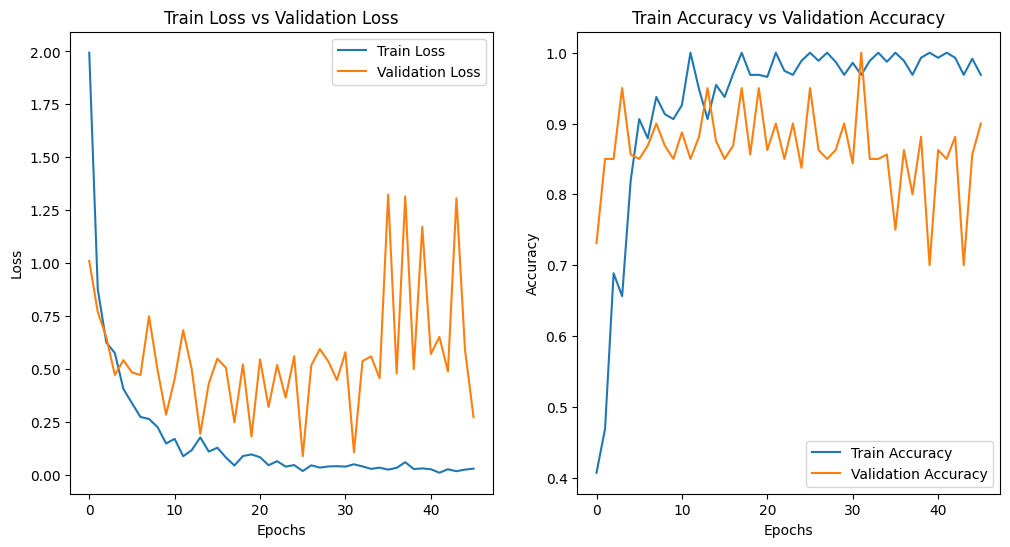

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


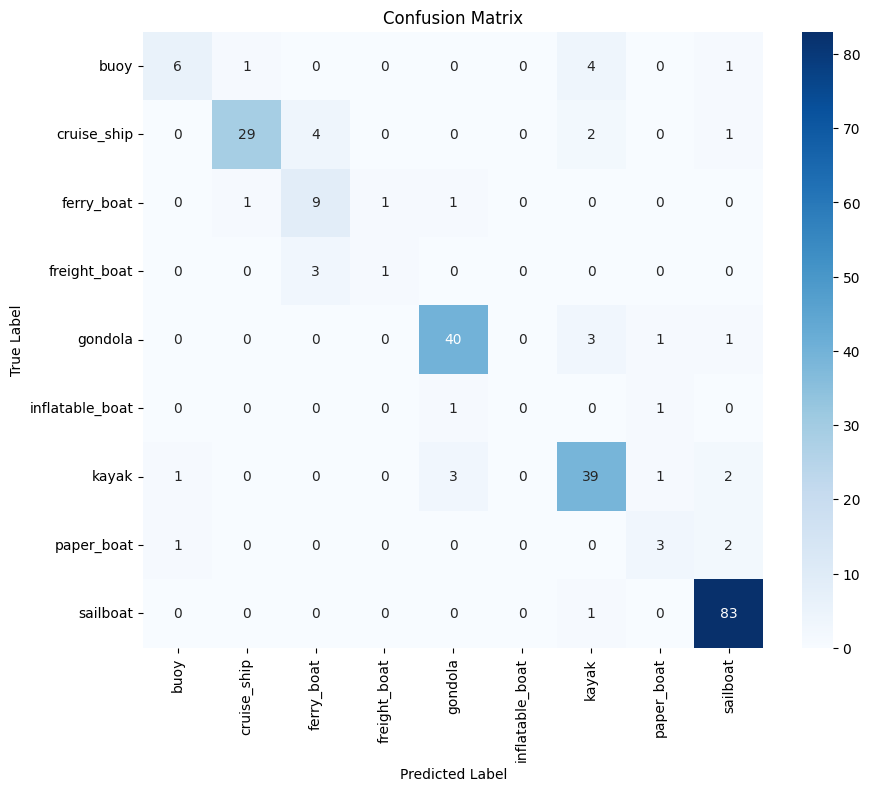

Classification Report
                 precision    recall  f1-score   support

           buoy       0.75      0.50      0.60        12
    cruise_ship       0.94      0.81      0.87        36
     ferry_boat       0.56      0.75      0.64        12
   freight_boat       0.50      0.25      0.33         4
        gondola       0.89      0.89      0.89        45
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.80      0.85      0.82        46
     paper_boat       0.50      0.50      0.50         6
       sailboat       0.92      0.99      0.95        84

       accuracy                           0.85       247
      macro avg       0.65      0.61      0.62       247
   weighted avg       0.84      0.85      0.84       247



/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [20]:
# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2, test_precision_v2, test_recall_v2 = model_v2.evaluate(test_generator_v2, verbose=1)

print(f'Test Loss: {test_loss_v2}')
print(f'Test Accuracy: {test_accuracy_v2}')
print(f'Test Precision: {test_precision_v2}')
print(f'Test Recall: {test_recall_v2}')

# Plotting Training vs Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Get the true labels and predictions
test_generator_v2.reset()
Y_pred = model_v2.predict(test_generator_v2)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator_v2.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator_v2.class_indices, yticklabels=test_generator_v2.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(test_generator_v2.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))
